# Monte Carlo Simulations in the Semi Grand Canonical Ensemble
The Semi Grand Canonical Ensemble (SGCE) is a useful ensemble when studying phases in alloys. In the SGCE the number of atoms is fixed, but the composition is allowed to vary. The ensemble is characterized by two parameters the temperature $T$ and chemical potentials $\mu_1,\mu_2 \dots \mu_{n-1}$ one for each element present except one which can be set to zero without loss of generality. Hence, there are $n-1$ chemical potentials.

## Cluster Expansion
The energy is expressed in the form of a cluster expansion (CE) (here only a binary alloy is considered, but it can generalized)
\begin{equation}
E(\mathbf{\sigma}) = c_0 + c_1 \sum_i \sigma_i + c_2 \sum_{\langle ij \rangle} \sigma_i \sigma_j + \cdots
\end{equation}

The chemical potential are substracted from the $c_1$ coefficient, and thus controls the composition in the alloy
\begin{equation}
E_{sgc}(\mathbf{\sigma}) = c_0 + (c_1-\mu) \sum_i \sigma_i + c_2 \sum_{\langle ij \rangle} \sigma_i \sigma_j + \cdots
\end{equation}

## Monte Carlo
Since the composition is allowed to vary, the monte carlo moves are summarized as
1. Select a random atom
2. Swap the symbol (i.e. Al $\rightarrow$ Mg)
3. With probabilty min$\left\{ 1, \exp(-(E_{new}-E_{old})/kT )\right\}$ accept the move.

## Free energy
The free energy $\Phi$ as a function of temperature and chemical potential is of high interest if for instance lattice transition is to be studied.
If the system consists of $N$ sites and $m$ elements
\begin{equation}
\frac{\Phi}{NkT} \rightarrow -\ln m \; \mathrm{as} \; T \rightarrow \infty
\end{equation}

Together with the exact differential 
\begin{equation}
d(\beta \Phi) = E_{sgc}d\beta - \beta \sum_i \sigma_i d\mu
\end{equation},
where $\beta=1/kT$,
the free energy can be computed at any temeprature and chemical potential using thermodynamic integration.
As each simulation is performed at constant $\mu$ it is convenient to integrate along paths of constant chemical potential, meaning that $d\mu=0$ and the free energy is given by
\begin{equation}
\beta \Phi(\beta,\mu_0) = \beta_0\Phi(\beta_0,\mu_0) + \int_{\beta_0}^{\beta_1} d\beta E_{sgc}
\end{equation}
As we typically specify temperature and not $\beta$ it is useful to change the integration variable from $\beta$ to $T$
\begin{equation}
\beta \Phi(\beta,\mu_0) = \beta_0\Phi(\beta_0,\mu_0) - \int_{T_0}^{T_1} dT \frac{E_{sgc}}{kT^2}
\end{equation}
As the temperature increases $E_{sgc}$ moves towards a constant $E_H$. To avoid lengthy simulations at extremely high temperatures, one can stop the simulations as soon as $E_{sgc}$ reaches a platou.
The free energy at this temperature is given by
\begin{equation}
\beta_H \Phi(T_H,\mu_0) = -\ln m - \frac{E_{sgc}}{k} \int_\infty^{T_H} \frac{dT}{T^2} = -\ln m + \frac{E_H}{kT_H}
\end{equation}

Based on this value the free energy at all other temperatures is given by
\begin{equation}
\beta \Phi(T,\mu_0) = \beta_H\Phi(T_H,\mu_0) - \int_{T_H}^T dT' \frac{E_{sgc}}{kT'^2}
\end{equation}

## Python Example

In [21]:
from cemc.mcmc import sgc_montecarlo as sgc    # Object running the Monte Carlo methods
from ase.ce.settings import BulkCrystal        # Object hosting the information about the clusters
from cemc.wanglandau.ce_calculator import CE   # Calculator that computes the energy for a given configuration

Initialize the BulkCrystal object

In [22]:
# ECIs (in this example they are just hardcoded)
eci = {"c3_1225_4_1": -0.0017448109612305434, 
 "c2_1000_1_1": -0.02253231472540913, 
 "c4_1225_8_1": 0.0015986520863819958, 
 "c2_707_1_1": 0.0020761708499214765, 
 "c4_707_1_1": -1.5475822532285122e-05, 
 "c4_1225_3_1": 0.0013284466570874605, 
 "c1_1": -1.068187483782512, 
 "c3_1225_2_1": -0.0015608053756936988, 
 "c3_1225_1_1": -0.0010685006728372629, 
 "c0": -2.6460513669066836, 
 "c4_1225_9_1": -7.3952137244461468e-05}

chem_pots = {
        "c1_1":-1.072 # Define the chemical potentials for the different singlet terms
    }

conc_args = {
            "conc_ratio_min_1":[[1,0]],
            "conc_ratio_max_1":[[0,1]],
        }
db_name = "database_with_dft_structures.db"
ceBulk = BulkCrystal( "fcc", 4.05, None, [10,10,10], 1, [["Al","Mg"]], conc_args, db_name, max_cluster_size=4, max_cluster_dia=1.414*4.05, reconf_db=True )

Generating cluster data. It may take several minutes depending on the values of max_cluster_size and max_cluster_dia...


In [23]:
# Initialize the calculator
calc = CE( ceBulk, eci )
ceBulk.atoms.set_calculator( calc )

In [24]:
# Specify some parameters characterizing the MC (consider far more steps than given here)
n_burn = 40    # Burn in steps to avoid initialial configuration bias
n_sample = 50  # Number of steps to sample

# Initialize the SGC MC object
T = 400 # Temperature in Kelvin
mc = sgc.SGCMonteCarlo( ceBulk.atoms, T, symbols=["Al","Mg"] )
mc.runMC( steps=n_burn, chem_potential=chem_pots )    # Burn-in
mc.runMC( steps=n_sample, chem_potential=chem_pots )  # Perform sampling

In [25]:
# Retrieve thermodynamic quantities
thermo_prop = mc.get_thermodynamic()
print (thermo_prop)

{'chem_pots': [-1.072], 'singlets': array([ 0.99019608]), 'heat_capacity': 0.00064070260317971336, 'energy': -2664.9423862198464, 'temperature': 400}


## Computing the Free Energy
One could now run Monte Carlo for a range of temeperatures and chemical potential and use this to compute the Free Energy. For the sake of just showing how to compute the Free Energy we just assume that we have these result and we just use some example values (we load them from a file of precomputed values)

In [26]:
# Read data from a file containing precomuted values
import json
import numpy as np
with open( "example_sgcmc_results.json", 'r' ) as infile:
    data = json.load(infile)
n_atoms = 1000.0
data = data["mu10720m"]
T = data["temperature"]
energy = np.array(data["energy"])/n_atoms
mu = {"c1_1":data["mu"]}
singlets = {"c1_1":data["singlets"]}

We can first look on the results

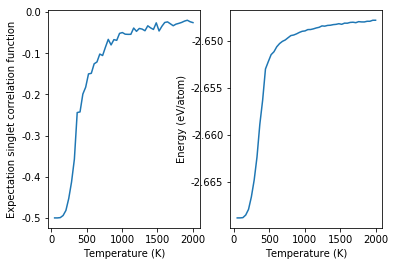

In [27]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.plot(T,singlets["c1_1"])
ax.set_xlabel( "Temperature (K)" )
ax.set_ylabel( "Expectation singlet correlation function" )

ax2 = fig.add_subplot(1,2,2)
ax2.plot(T,energy)
ax2.set_xlabel( "Temperature (K)" )
ax2.set_ylabel( "Energy (eV/atom)")

We see that the energy starts to flatten out although it has not completely reached a platou. But we still apply the approximation that $E(T>2000K) \approx E(T=2000K)$. We use the FreeEnergy class from the cemc module to calculate the free energy.

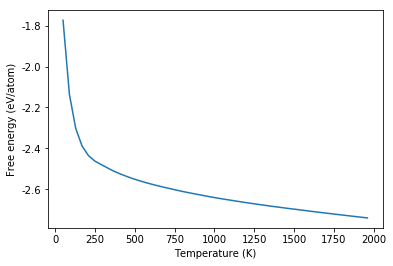

In [28]:
from cemc.tools import free_energy as fe
free = fe.FreeEnergy()

# First we need to get the proper energy in the SGC ensamble
sgc_energy = free.get_sgc_energy( energy, singlets, mu )
res = free.free_energy_isochemical( T=T, sgc_energy=sgc_energy, nelem=2 )

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Important: Use the temperature of the res dictionary rather than the original
# The FreeEnergy class sorts the the values based on temperature which may
# change the order 
ax.plot( res["temperature"], res["free_energy"] )
ax.set_xlabel( "Temperature (K)" )
ax.set_ylabel( "Free energy (eV/atom)" )

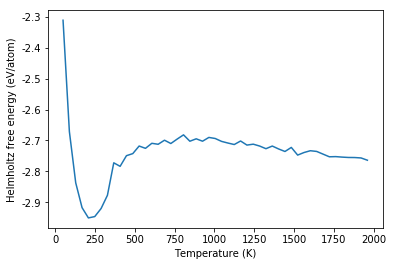

In [29]:
# The helmholtz energy can also be computed
# Remember that the singlets have to appear in the correct order
# The order at which the elements are sorted is given in the res variable
new_singlets = {}
for key in singlets.keys():
    new_singlets[key] = np.array( [singlets[key][indx] for indx in res["order"]] )
helmholtz = free.helmholtz_free_energy( res["free_energy"], mu, new_singlets )

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot( res["temperature"], helmholtz )
ax.set_xlabel( "Temperature (K)" )
ax.set_ylabel( "Helmholtz free energy (eV/atom)" )

The ripples is caused by the ripples in the singlet 